# POSEIDON: Pose Estimation & Activity Recognition using GNNs

Team Members (Group 16): 
1. Chong Jun Rong Brian (A0290882U)
2. Parashara Ramesh (A0285647M)
3. Ng Wei Jie Brandon (A0184893L)

In [1]:
%load_ext autoreload
%autoreload 2

<h2><u> Table of contents </u></h2>

1. What is this project about?
<br> 1.1. Project Motivation
<br> 1.2. Project Description
<br> 1.3. Project Setup   
2. Human 3.6M Dataset
<br> 2.1. Summary of the dataset
<br> 2.2. Preparing the dataset
<br> 2.3. Visualizing poses
3. Dataset preparation
4. Models
5. Baseline 1 - SimplePose (Simple ML model without using GNNs)
6. Baseline 2 - SimplePoseGNN (Simple ML model using GNNs) 
7. Improvement 1 - SemGCN model (Reimplementation of Semantic GCN)
8. Improvement 2 - PoseGCN model (Tweaks of SemGCN)
9. Evaluation & Analysis of models
10. Creating our own custom dataset
11. Evaluation on custom dataset
12. Conclusion
13. Video presentation & Resources


<h2><u>1. What is this project about?</u></h2>
<h3><u>1.1 Project Motivation</u></h3>

Accurately predicting 3D human poses from 2D keypoints is a critical task for many applications such as motion capture and activity recognition. Traditional methods that use direct regression or lifting techniques often struggle to fully capture the complex spatial relationships between body joints. By treating the 2D pose keypoints as graphs, we can leverage the underlying connectivity between joints to improve the 3D pose estimation. Additionally, recognizing and classifying human activities from these poses is an essential task in fields like surveillance and healthcare. Therefore, this project seeks to explore how GNNs can enhance 3D pose estimation and activity recognition.

<h3><u>1.2 Project Description</h3></u>

The primary objective of this project is to predict 3D human poses from 2D pose keypoints accurately using GNNs. 
* Firstly, we will develop two baseline models: one using standard Neural Network (NN) & Convolutional Neural Network (CNN) followed by a simple GNN based model both for 3d pose estimation 
* Secondly, we will reimplement the SemGCN model, which treats the body joints of a 2D pose as nodes in a graph, with edges representing the connectivity between them. 
* Finally, we will design an improved version of the SemGCN model by exploring different GNN architectures and modifications to enhance its performance.

The secondary objective is to classify human activities based on 2D pose keypoints. We will use custom datasets to validate this task, allowing us to assess the generalization capabilities of GNN-based models for activity recognition.

<h3><u>1.3 Project Setup</u></h3>

1. Install the dependencies from requirements.txt using the command

`pip install -r requirements.txt`


<h2><u>2. Human 3.6M Dataset</u></h2>

<h3><u>2.1 Summary of the dataset </u></h3>

The [Human 3.6M dataset](http://vision.imar.ro/human3.6m/description.php) is a large-scale collection of 3.6 million 3D human poses captured from 11 professional actors in 17 everyday scenarios (e.g., talking, smoking, discussing). It includes synchronized video from multiple calibrated cameras, precise 3D joint positions and angles, and pixel-level body part labels. Additional data like time-of-flight range data and 3D laser scans of actors are also available.

The dataset comes with precomputed image descriptors, tools for visualizing and predicting human poses, and an evaluation set for benchmarking performance, making it a rich resource for 3D human pose estimation, action recognition, and related computer vision tasks.

<h3><u>2.2. Dataset preparation </u></h3>

Downloading the dataset from the website requires a login , therefore we will be directly using a preprocessed version of this dataset stored in google drive [here](https://drive.google.com/file/d/1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s/view?usp=drive_link).
 
Original preprocessing was done by [Martinez et al](https://github.com/una-dinosauria/3d-pose-baseline) from this repository.

The cells below go through the steps of downloading this preprocessed dataset and creating train-test files from it after some transformation. 

From section 3(Models) we will be directly using the created train-test files, therefore the cells under this section need not be executed.

#### Downloading the zip from google drive

In [2]:
# Download the zip from google drive
import gdown
import os

# file id from gdrive (refer to markdown cell above for full link)
file_id = '1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s' 
download_url = f'https://drive.google.com/uc?id={file_id}'

# Folder where you want to save the file
folder_path = os.path.join(os.getcwd(),"datasets", "h36m", "Original")
zip_file_path = os.path.join(folder_path, 'h36m.zip')

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Download the ZIP file
gdown.download(download_url, zip_file_path, quiet=False)

print(f"Downloaded ZIP file and saved to {zip_file_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s
From (redirected): https://drive.google.com/uc?id=1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s&confirm=t&uuid=4e14a109-59cf-49a1-9afc-5aa1d15be11c
To: C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Original\h36m.zip
100%|██████████| 260M/260M [00:28<00:00, 8.99MB/s] 

Downloaded ZIP file and saved to C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Original\h36m.zip


#### Extracting the contents into the same folder

In [3]:
# extracting the contents inside the /datasets/h36m/Original folder
import zipfile

print(f"Extracting files to {folder_path}..")
# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

print(f"Finished extracting files to {folder_path}")



Extracting files to C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Original..
Finished extracting files to C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Original


#### Saving the 3d positions into a compressed np file

In [4]:
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np

output_filename = os.path.join(folder_path, 'data_3d_h36m')
subjects = ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']

output = dict()
for subject in tqdm(subjects, desc= f'Processing subjects..'):
    output[subject] = dict()
    file_list = glob(os.path.join(folder_path, 'h36m', subject, 'MyPoses', '3D_positions', '*.h5'))
    assert len(file_list) == 30, "Expected 30 files for subject " + subject + ", got " + str(len(file_list))
    for f in file_list:
        action = os.path.splitext(os.path.basename(f))[0]

        if subject == 'S11' and action == 'Directions':
            continue  # Discard corrupted video

        with h5py.File(f) as hf:
            positions = hf.get('3D_positions')[:].reshape(32, 3, -1).transpose(2, 0, 1)
            positions /= 1000  # Meters instead of millimeters
            output[subject][action] = positions.astype('float32')

print(f'Saving compressed 3d positions into {output_filename}')
np.savez_compressed(output_filename, positions_3d=output)
print(f'Finished saving 3d positions into {output_filename}')
del output


Processing subjects..: 100%|██████████| 7/7 [00:01<00:00,  5.42it/s]


Saving compressed 3d positions into C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Original\data_3d_h36m
Finished saving 3d positions into C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Original\data_3d_h36m


#### Compute the ground truth 2d poses.

TODO.brandon explain what the human35mDataset constructor does in detail (intrinsics, extrinsics etc)

In [5]:
from data.camera import world_to_camera, project_to_2d, image_coordinates, wrap
from data.h36m_dataset import Human36mDataset

print('Computing ground-truth 2D poses...')
output_filename_2d = os.path.join(folder_path, 'data_2d_h36m_gt')

dataset = Human36mDataset(output_filename + '.npz')
output_2d_poses = {}
for subject in dataset.subjects():
    output_2d_poses[subject] = {}
    for action in dataset[subject].keys():
        anim = dataset[subject][action]

        positions_2d = []
        for cam in anim['cameras']:
            pos_3d = world_to_camera(anim['positions'], R=cam['orientation'], t=cam['translation'])
            pos_2d = wrap(project_to_2d, True, pos_3d, cam['intrinsic'])
            pos_2d_pixel_space = image_coordinates(pos_2d, w=cam['res_w'], h=cam['res_h'])
            positions_2d.append(pos_2d_pixel_space.astype('float32'))
        output_2d_poses[subject][action] = positions_2d

print(f'Saving compressed 2d positions into {output_filename_2d}')
metadata = {
    'num_joints': dataset.skeleton().num_joints(),
    'keypoints_symmetry': [dataset.skeleton().joints_left(), dataset.skeleton().joints_right()]
}
np.savez_compressed(output_filename_2d, positions_2d=output_2d_poses, metadata=metadata)

print(f'Done saving compressed 2d positions into {output_filename_2d}')
del output_2d_poses

Computing ground-truth 2D poses...
Saving compressed 2d positions into C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Original\data_2d_h36m_gt
Done saving compressed 2d positions into C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Original\data_2d_h36m_gt


Cleanup the extracted files and the downloaded zip

In [6]:
from shutil import rmtree

rmtree(os.path.join(folder_path, 'h36m'))
os.remove(os.path.join(folder_path, 'h36m.zip'))

#### Creating and saving train and test files from the saved npz files

In [7]:
from utils.data_utils import read_3d_data, create_2d_data, create_train_test_files
from data.h36m_dataset import TRAIN_SUBJECTS, TEST_SUBJECTS, Human36mDataset
import os

subjects_train = TRAIN_SUBJECTS
subjects_test = TEST_SUBJECTS

processed_dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Processed")
os.makedirs(processed_dataset_path, exist_ok=True)

dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_3d_h36m.npz")
dataset = Human36mDataset(dataset_path)


In [8]:
print("Reading 3d npz file")
dataset = read_3d_data(dataset)

print("Reading 2d npz file")
dataset_2d_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_2d_h36m_gt.npz")
keypoints = create_2d_data(dataset_2d_path, dataset)
print("Done")

Reading 3d npz file
Reading 2d npz file
Done


In [9]:
print("Creating train datasets and saving into file")
_, _, _ = create_train_test_files(subjects_train, dataset, keypoints, "train", processed_dataset_path)

print("Creating test datasets and saving into file")
_, _, _ = create_train_test_files(subjects_test, dataset, keypoints, "test", processed_dataset_path)
print("Done")

Creating train datasets and saving into file
Saved pose actions in file C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Processed\train_actions.npy
Saved 3d poses in file C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Processed\train_3d_poses.npy
Saved 2d poses in file C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Processed\train_2d_poses.npy
Creating test datasets and saving into file
Saved pose actions in file C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Processed\test_actions.npy
Saved 3d poses in file C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Processed\test_3d_poses.npy
Saved 2d poses in file C:\Parashara\Projects\NUS projects\Sem3\Graph ML\Poseidon\datasets\h36m\Processed\test_2d_poses.npy
Done


<h3><u>2.3 Visualizing poses </u></h3>

Since we have saved the train and test files, we will now only use those files for the rest of the notebook.

This has also been saved directly in this [google drive link](https://drive.google.com/drive/folders/1d38hWSM8clZlI11nqljxBECog1KY-iTd?usp=sharing), which can be placed directly in the local path instead of executing previous cells

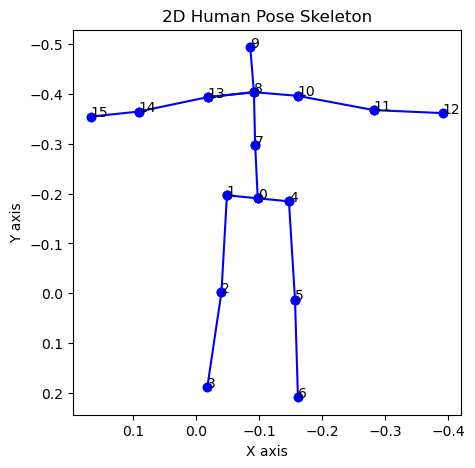

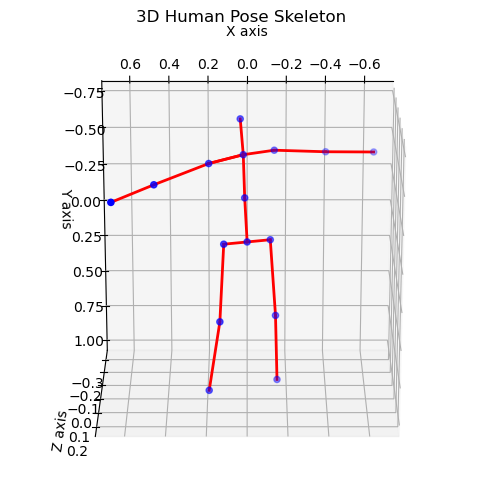

In [10]:
import numpy as np

from utils.visualization_utils import visualize_2d_pose, visualize_3d_pose

poses_2d = np.load("datasets/h36m/Processed/test_2d_poses.npy")
poses_3d = np.load("datasets/h36m/Processed/test_3d_poses.npy")

visualize_2d_pose(poses_2d[0])
visualize_3d_pose(poses_3d[0], elev=110, azim=90)

Finding out the distribution of actions in the train and test splits

In [ ]:
#TODO.parash bar graphs

<h2><u>3. Models</u></h2>

TODO.all - write a convincing story on our approach + high level thoughts on why the following models are worth building and what we hope to gain from it





In [18]:
# Simple Model based on A Simple yet effective baseline for 3D Pose Estimation
class LinearBaselineModel(nn.Module):
    
    def __init__(self, total_joints, total_actions):
        super().__init__()
        self.total_joints = total_joints,
        self.total_actions = total_actions
        self.input_linear = nn.Linear(total_joints * 2, 1024) # 1d input shape is B x 16 x 2
        self.block1 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.block2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.output_3d_pose_linear = nn.Linear(1024, total_joints * 3) # 3D output shape is B x 16 x 3
        self.output_label_linear = nn.Linear(1024, total_actions) # Predict Action Labels
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.input_linear(x)
        x = self.block1(x) + x # First Residual connection
        x = self.block2(x) + x # Second Residual Connection
        three_dim_pose_predictions = self.output_3d_pose_linear(x)
        action_label_predictions = self.output_label_linear(x)
        joint_preds = three_dim_pose_predictions.view(x.shape[0], -1, 3)
        action_preds = action_label_predictions
        return joint_preds, action_preds   # 3D output shape is B x 16 x 3
        

<h2><u>4. Baseline 1 - SimplePose (Simple ML model without using GNNs)</u></h2>

TODO.brian

In [19]:
# Dataset Class
class Human36MDataset(Dataset):
    def __init__(self, two_d_dataset_path, three_d_dataset_path, label_dataset_path):
        self.two_d_dataset_path = two_d_dataset_path
        self.three_d_dataset_path = three_d_dataset_path
        self.label_dataset_path = label_dataset_path
        self.input_data = np.load(self.two_d_dataset_path)
        self.output_data = np.load(self.three_d_dataset_path)
        self.labels = np.load(self.label_dataset_path)
        unique_labels, tags = np.unique(self.labels, return_inverse=True)
        self.unique_labels = unique_labels
        self.labels = tags
        self.labels_map = dict(zip(range(len(unique_labels)),unique_labels))
        assert len(self.input_data) == len(self.labels) == len(self.output_data)
    
    def get_action_numbers(self):
        return len(self.unique_labels)
    
    def get_joint_numbers(self):
        return self.input_data[0].shape[0]
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, index):
        return self.input_data[index], self.output_data[index], self.labels[index]

In [20]:

# Parameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
NUM_EPOCHS = 200
DEVICE = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu') 

training_2d_dataset_path = os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy')
training_3d_dataset_path = os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy')
training_label_path  = os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy')
training_data = Human36MDataset(training_2d_dataset_path, training_3d_dataset_path, training_label_path)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
testing_2d_dataset_path = os.path.join('datasets', 'h36m', 'Processed', 'test_2d_poses.npy')
testing_3d_dataset_path = os.path.join('datasets', 'h36m', 'Processed', 'test_3d_poses.npy')
testing_label_path  = os.path.join('datasets', 'h36m', 'Processed', 'test_actions.npy')
testing_data = Human36MDataset(testing_2d_dataset_path, testing_3d_dataset_path, testing_label_path)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

def kaiming_weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)

TOTAL_JOINTS = training_data.get_joint_numbers()
TOTAL_ACTIONS = training_data.get_action_numbers()

# Declare Model
model = LinearBaselineModel(TOTAL_JOINTS, TOTAL_ACTIONS).to(DEVICE)
# Apply Kaiming Init on Linear Layers
model.apply(kaiming_weights_init)

print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Declare Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Declare Scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96) # Value used by the original authors

# Loss Function
three_dim_pose_estimation_loss_fn = nn.MSELoss()
action_label_loss_fn = nn.CrossEntropyLoss()

# Training Loop
global_total_losses = []
global_pose_losses = []
global_action_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    predicted_labels = None
    true_labels = None
    total_losses = []
    pose_losses = []
    action_losses = []
    for data in tqdm(train_dataloader):
        # Prepare Data
        two_dim_input_data, three_dim_output_data, action_labels= data
        two_dim_input_data = two_dim_input_data.to(DEVICE)
        three_dim_output_data = three_dim_output_data.to(DEVICE)
        action_labels = action_labels.to(DEVICE)
        # Set Gradients to 0
        optimizer.zero_grad()
        # Train Model
        predicted_3d_pose_estimations, predicted_action_labels = model(two_dim_input_data)
        # Calculate Loss
        three_dim_pose_estimation_loss = three_dim_pose_estimation_loss_fn(predicted_3d_pose_estimations, three_dim_output_data)
        action_label_loss = action_label_loss_fn(predicted_action_labels, action_labels)
        loss = three_dim_pose_estimation_loss + action_label_loss
        if epoch % 10 == 0: # Every 10 epochs, report once
            # Store Results
            total_losses.append(loss)
            pose_losses.append(three_dim_pose_estimation_loss)
            action_losses.append(action_label_loss)
            predicted_action_labels = torch.argmax(predicted_action_labels, axis=1)
            predicted_labels = predicted_action_labels if predicted_labels is None else torch.cat((predicted_labels, predicted_action_labels), axis=0)
            true_labels = action_labels if true_labels is None else torch.cat((true_labels, action_labels), axis=0)
        # Optimize Gradients and Update Learning Rate
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Every 10 epochs, report once
    if epoch % 10 == 0:
        correct_predictions = (predicted_labels == true_labels).sum().item()
        accuracy = correct_predictions / predicted_labels.size(0) * 100
        total_loss = sum(total_losses) / len(train_dataloader)
        pose_loss = sum(pose_losses) / len(train_dataloader)
        action_loss = sum(action_losses) / len(train_dataloader)
        global_total_losses.append(total_loss)
        global_action_losses.append(action_loss)
        global_pose_losses.append(pose_loss)
        print(f"Epoch: {epoch} | Total Training Loss: {total_loss} | Pose Training Loss: {pose_loss} | Action Training Loss: {action_loss} | Action Train Label Accuracy: {accuracy}")
    
    if epoch % 10 == 0: # Every 10 epochs, test once
        predicted_labels = None
        true_labels = None
        total_losses = []
        pose_losses = []
        action_losses = []
        for data in tqdm(test_dataloader):
            # Prepare Data
            two_dim_input_data, three_dim_output_data, action_labels= data
            two_dim_input_data = two_dim_input_data.to(DEVICE)
            three_dim_output_data = three_dim_output_data.to(DEVICE)
            action_labels = action_labels.to(DEVICE)
            # Predict with model
            predicted_3d_pose_estimations, predicted_action_labels = model(two_dim_input_data)
            # Calculate Loss
            three_dim_pose_estimation_loss = three_dim_pose_estimation_loss_fn(predicted_3d_pose_estimations, three_dim_output_data)
            action_label_loss = action_label_loss_fn(predicted_action_labels, action_labels)
            loss = three_dim_pose_estimation_loss + action_label_loss
            # Store Results
            total_losses.append(loss)
            pose_losses.append(three_dim_pose_estimation_loss)
            action_losses.append(action_label_loss)
            predicted_action_labels = torch.argmax(predicted_action_labels, axis=1)
            predicted_labels = predicted_action_labels if predicted_labels is None else torch.cat((predicted_labels, predicted_action_labels), axis=0)
            true_labels = action_labels if true_labels is None else torch.cat((true_labels, action_labels), axis=0)
        
        # Calculate Test Accuracy
        correct_predictions = (predicted_labels == true_labels).sum().item()
        accuracy = correct_predictions / predicted_labels.size(0) * 100
        total_loss = sum(total_losses) / len(train_dataloader)
        pose_loss = sum(pose_losses) / len(train_dataloader)
        action_loss = sum(action_losses) / len(train_dataloader)
        print(f"Epoch: {epoch} | Total Testing Loss: {total_loss} | Pose Testing Loss: {pose_loss} | Action Testing Loss: {action_loss} | Action Test Label Accuracy: {accuracy}")
    
# Save model
state_dict = {
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
    'scheduler': scheduler.state_dict(),
}
weight_save_path = os.path.join('weights', 'linear_baseline_model')
if not os.path.exists(weight_save_path):
    os.makedirs(weight_save_path)

torch.save(state_dict, os.path.join(weight_save_path, 'weights.pth'))

Model Parameters: 4304959


100%|██████████| 24372/24372 [01:22<00:00, 294.96it/s]


Epoch: 0 | Total Training Loss: 5.275071620941162 | Pose Training Loss: 2.327385663986206 | Action Training Loss: 2.947679042816162 | Action Train Label Accuracy: 20.014463837840886


  0%|          | 1/200 [02:20<7:45:55, 140.48s/it]

Epoch: 0 | Total Testing Loss: 1.9314818382263184 | Pose Testing Loss: 0.8192713260650635 | Action Testing Loss: 1.1122114658355713 | Action Test Label Accuracy: 16.10195382667334


  0%|          | 1/200 [03:49<12:39:46, 229.08s/it]


KeyboardInterrupt: 

<h2><u>5. Baseline 2 - SimplePoseGNN (Simple ML model using GNNs)</u></h2>

TODO.brandon

<h2><u>6. Improvement 1 - SemGCN model (Reimplementation of Semantic GCN)</u></h2>

TODO.parash


<h2><u>7. Improvement 2 - PoseGCN model (Tweaks of SemGCN)</u></h2>

TODO.all

<h2><u>8. Evaluation & Analysis of models<u></h2>

<h2><u>9. Creating our own custom dataset</u></h2>

<h2><u>10. Evaluation on custom dataset</u></h2>

<h2><u>11. Conclusion</u></h2>

<h2><u>12. Video presentation & Resources</u></h2>